In [12]:
import pandas as pd, numpy as np, torch, matplotlib.pyplot as plt, re
from sklearn.model_selection import train_test_split

In [24]:
df=pd.read_csv('/Users/srishtysuman/PycharmProjects/NaturalLanguageProcessing/quora_question_pair_data/train.csv')
df=df.iloc[:4000]

def clean(text):
    if text=='' or pd.isnull(text) or type(text)!=str:
        return ''
    text=text.lower()
    text=re.sub(r'[^a-zA-Z]+', ' ', text)
    return text
df["question1"]=df["question1"].apply(lambda x: clean(x))
df["question2"]=df["question2"].apply(lambda x: clean(x))

df=df[df["question1"].apply(lambda x: len(x)>1)]
df=df[df["question2"].apply(lambda x: len(x)>1)]

class VocabAndMap:
    def __init__(self):
        self.n_word=2
        self.word2index={}
        self.index2word={0:'sos', 1: 'eos'}
    def addSentence(self, ques):
        ques_map=[]
        for word in ques.split(' '):
            if word not in self.word2index:
                self.word2index[word]=self.n_word
                self.index2word[self.n_word]=word
                ques_map.append(self.n_word)
                self.n_word+=1
            else:
                ques_map.append(self.word2index[word])
        return ques_map
    
build_vocab_and_map=VocabAndMap()
df["ques1_map"]=df["question1"].apply(lambda x: build_vocab_and_map.addSentence(x))
df["ques2_map"]=df["question2"].apply(lambda x: build_vocab_and_map.addSentence(x))
df=df[df["ques1_map"].apply(lambda x: len(x)>0)]
df=df[df["ques2_map"].apply(lambda x: len(x)>0)]

df_x=df[["ques1_map", "ques2_map"]]
df_y=df["is_duplicate"]


train_x, test_x, train_y, test_y=train_test_split(df_x, df_y, stratify=df_y, shuffle=True)

ques1=train_x["ques1_map"].tolist()
ques2=train_x["ques2_map"].tolist()
labels=train_y.tolist()

class Dataset:
    def __init__(self, ques1, ques2, labels):
        self.ques1=ques1
        self.ques2=ques2
        self.labels=labels
    
    def __len__(self):
        return len(self.ques1)
    
    def __getitem__(self, index):
        return {
            "ques1": self.ques1[index],
            "ques2": self.ques2[index],
            "label": self.labels[index]
        }

def collate_fn(batch):
    ques1_list=[]
    ques2_list=[]
    labels=[]

    for i in range(len(batch)):
        ques1_list.append(batch[i]["ques1"])
        ques2_list.append(batch[i]["ques2"])
        labels.append(batch[i]["label"])
    
    q1_length=[len(q) for q in ques1_list]
    q2_length=[len(q) for q in ques2_list]

    return {
        "ques1": ques1_list,
        "ques2": ques2_list,
        "q1_length": q1_length,
        "q2_length": q2_length,
        "labels": labels
    }

train_data=Dataset(ques1, ques2, labels)

for sample in train_data:
    print(sample)
    break

train_dataloader=torch.utils.data.DataLoader(train_data, collate_fn=collate_fn, batch_size=32)

{'ques1': [2, 3, 4, 2680, 117, 127, 10, 1877, 782, 14], 'ques2': [2, 3, 4, 2680, 16, 1877, 782, 117, 127, 14], 'label': 1}


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


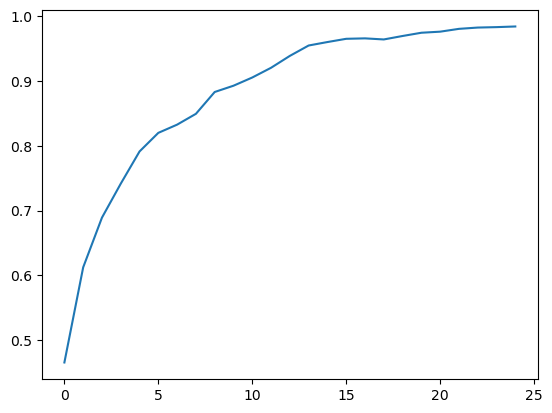

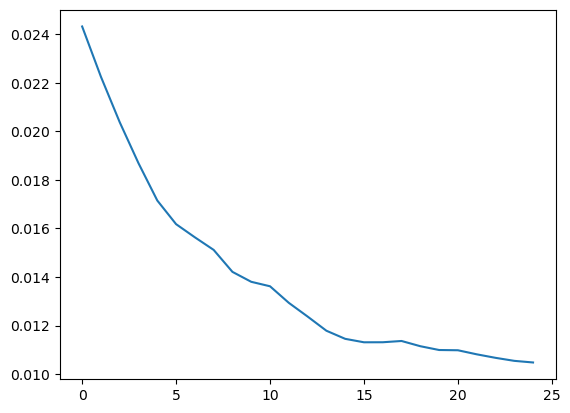

In [47]:
class EncoderLSTM(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.embedding=torch.nn.Embedding(vocab_size, hidden_size)
        self.lstm=torch.nn.LSTM(hidden_size, hidden_size)
        self.linear1=torch.nn.Linear(hidden_size, hidden_size)
        self.relu=torch.nn.ReLU()
        self.linear2=torch.nn.Linear(hidden_size, hidden_size)
        self.final=torch.nn.Sigmoid()

    def encode(self, ques, length):
        length=np.flipud(np.sort(length))
        length=length.copy()
        sorted_indices=np.flipud(np.argsort(length))

        ques=[torch.LongTensor(ques[i]).to('cpu') for i in sorted_indices]
        ques=torch.nn.utils.rnn.pad_sequence(ques, batch_first=True)

        embedded=self.embedding(ques).to('cpu')
        
        packed=torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths=length, batch_first=True)
        out, (hn, cn)=self.lstm(packed)
        unpacked=torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length=int(length[0]))

        out=self.linear2(self.relu(self.linear1(hn)))
        out=out.permute(1,0,2)

        unsorted_out=torch.zeros(out.size())
        for i, encode in enumerate(out):
            unsorted_out[sorted_indices[i]]=encode
        return unsorted_out.squeeze(1)       

    def forward(self, ques1, ques2, q1_length, q2_length):
        encode_q1=self.encode(ques1, q1_length)
        encode_q2=self.encode(ques2, q2_length)

        similarity=torch.nn.functional.cosine_similarity(encode_q1, encode_q2)
        similarity=torch.nn.Sigmoid()(similarity)

        return similarity

loss_history=[]
accuracy_history=[]
model=EncoderLSTM(build_vocab_and_map.n_word, 128)
loss_fn=torch.nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
for i in range(25):
    print(i)
    losses=[]
    correct=0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred=model(batch["ques1"], batch["ques2"], batch["q1_length"], batch["q2_length"])
        pred_label=(y_pred>0.5).float()
        y=torch.tensor(batch["labels"], dtype=torch.float32).to('cpu')
        correct+=(pred_label==y).sum()
        loss=loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    loss_history.append(sum(losses)/len(ques1))
    accuracy_history.append(correct/len(ques1))

plt.plot(np.arange(len(accuracy_history)), accuracy_history)
plt.show()

plt.plot(np.arange(len(loss_history)), loss_history)
plt.show()
